# Integrated Advertising & Pricing - Single Price

In [4]:
import sys
sys.path.insert(1, '../P2P3/')

import random
import numpy as np
import matplotlib.pyplot as plt
from bidding_environment import *
from pricing_environment import *
from ts_learner import *
from gpts_learner import *
from data import p, n_for_b, ad_pricing_range_max, p_star
from ILP_knapsack import *
import math
import pulp
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


# Sets initial data
n_arms_ads = 25 # number of arms for advertising
n_arms_pricing = 8 # number of arms for pricing

N = 10 # N of experiments
T = 200 # T for Times
min_bid = 0.0
max_bid = 1.0
bids = np.linspace(min_bid, max_bid, n_arms_ads) # bids are a linspace

sigma = 5

# Presets regrets and rewards that are going to be computed
regrets_per_subcampaign = []
rewards_per_subcampaign = []

price_min = 50.0
price_max = 70.0

prices = np.linspace(price_min, price_max, n_arms_pricing)



In [5]:
all_regrets = []
cum_regrets = []


for e in range(N):
    
    ad_envs = [BiddingEnvironment(bids, sigma, subcampaign=subcampaign) for subcampaign in [1,2,3]]
    meta_gpts_learners = [GPTS_Learner(n_arms=n_arms_ads, arms=bids, plain_gp=True) for subcampaign in [1,2,3]]
    allocations = [
        {1:20, 2:2, 3:2}
    ]


    pricing_envs = [PricingEnvironment(n_arms=n_arms_pricing, prices=prices, p=p_star, subcampaign=subcampaign) for subcampaign in [1,2,3]]
    ts_learners = [TS_Learner(n_arms=n_arms_pricing) for subcampaign in [1,2,3]]

    single_ts_learner = TS_Learner(n_arms=n_arms_pricing)

    meta_rew = [
        ad_envs[0].means * np.max(pricing_envs[0].prices*pricing_envs[0].probabilities(pricing_envs[0].prices)) - bids*ad_pricing_range_max[1] ,
        ad_envs[1].means * np.max(pricing_envs[1].prices*pricing_envs[1].probabilities(pricing_envs[1].prices)) - bids*ad_pricing_range_max[2] ,
        ad_envs[2].means * np.max(pricing_envs[2].prices*pricing_envs[2].probabilities(pricing_envs[2].prices)) - bids*ad_pricing_range_max[3] 
    ]

    best = ILP_knapsack(bids, meta_rew, 1.0)
    regret_for_ads = [[],[],[]]

    restart = 10
    cutoff = 80
    

    for t in tqdm(range(T)):
        # 3 subcampaigns:
        rewards_per_subcampaign = []
        if t < cutoff and t % restart == 0:
            r1 = random.choice(range(n_arms_ads))
            r2 = random.choice(range(n_arms_ads))
            r3 = random.choice(range(n_arms_ads))

            allocations.append({
                1: r1,
                2: r2,
                3: r3
            })
        for subcampaign in [1, 2, 3]:
            ad_bid_to_try = allocations[-1][subcampaign] # pull the allocated arm
            n_clicks = ad_envs[subcampaign-1].round(ad_bid_to_try) # gets another random value from it
            rewards_from_ad = 0

            for nc in range(int(n_clicks)):
                price_to_try = single_ts_learner.pull_arm()
                
                reward = pricing_envs[subcampaign-1].round(price_to_try)
                rewards_from_ad += (reward*prices[price_to_try])
                
                single_ts_learner.update(price_to_try, reward)

            rewards_from_ad -= (bids[ad_bid_to_try] * ad_pricing_range_max[subcampaign] )
            regret_for_ads[subcampaign-1].append(meta_rew[subcampaign-1][best[subcampaign]] - rewards_from_ad)

            meta_gpts_learners[subcampaign-1].update(ad_bid_to_try, rewards_from_ad) # updates the learner
            # Appends to the rewards the values at lower CI
            rewards_per_subcampaign.append(np.random.normal(meta_gpts_learners[subcampaign-1].means, meta_gpts_learners[subcampaign-1].sigmas))
        allocations.append(ILP_knapsack(bids, rewards_per_subcampaign, 1.0))

    all_regrets.append(regret_for_ads)
    cum_regrets.append(np.cumsum(np.sum(regret_for_ads, axis=0)))

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:27<00:00,  7.18it/s]


# Single Regrets - 1 Experiment

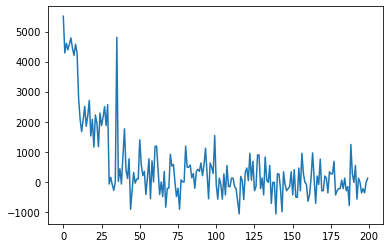

In [6]:
plt.plot(np.sum(regret_for_ads, axis=0))

# Cumulative Regrets - 1 Experiment

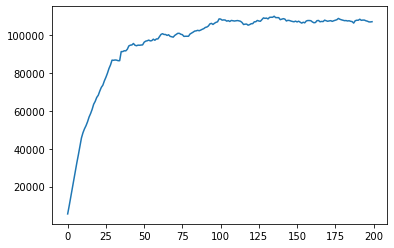

In [7]:
plt.plot(np.cumsum(np.sum(regret_for_ads, axis=0)))

# Cumulative Regrets - Multiple Experiments 

Text(0, 0.5, 'Cumulative Regret')

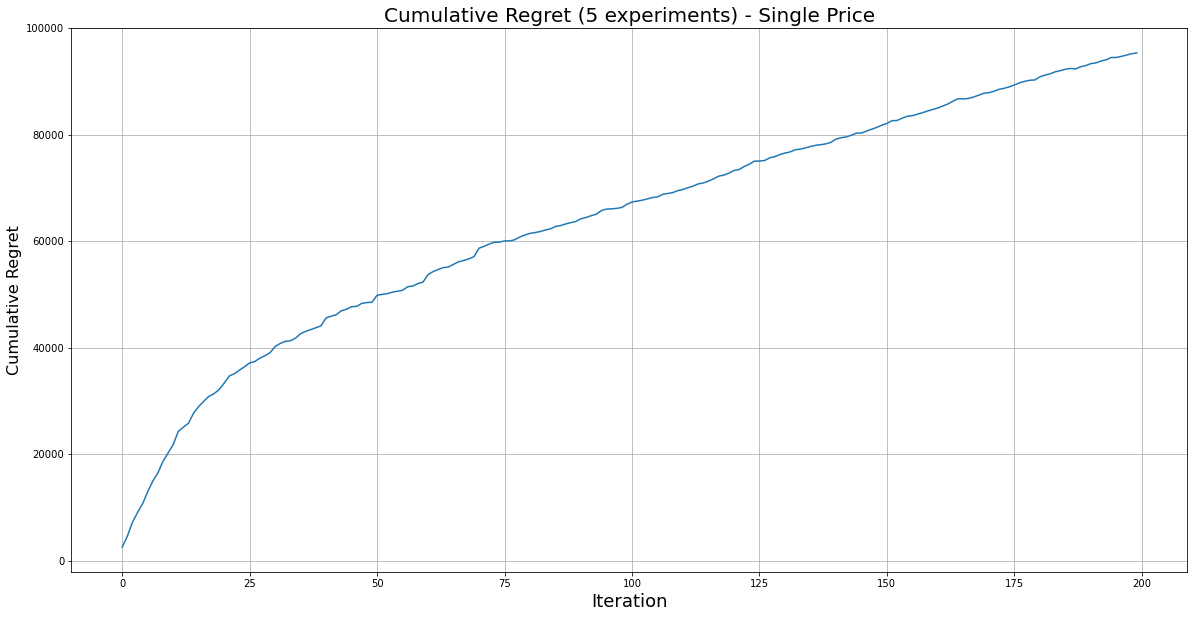

In [8]:
res = []
for r in all_regrets:
        res.append(np.cumsum(np.sum(r, axis=0)))
        
plt.figure(figsize=(20,10))
plt.plot(np.mean(res, axis=0))
plt.grid()
plt.title('Cumulative Regret (5 experiments) - Single Price', fontsize=20)
plt.xlabel('Iteration', fontsize=18)
plt.ylabel('Cumulative Regret', fontsize=16)